### Imports

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold , train_test_split 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [23]:
base_path = Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/data/data_splits")
plotdir= Path("/Users/tusharsingh/Work/Project/tcga-mldl/results/plots")
split_sets = {
    # "5pct_80": base_path / "5pct_80",
    # "15pct_80": base_path / "15pct_80",
    "25pct_80": base_path / "25pct_80"
}

### Load Data

In [24]:
def load_split_data(split_path):
    split_path = Path(split_path)
    X_train = pd.read_csv(split_path / "X_train.csv", index_col=0)
    X_test = pd.read_csv(split_path / "X_test.csv", index_col=0)
    y_train = pd.read_csv(split_path / "y_train.csv", index_col=0).squeeze()
    y_test = pd.read_csv(split_path / "y_test.csv", index_col=0).squeeze()

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    return X_train, y_train, X_val, X_test, y_val, y_test


### XGBoost GridSearchCV Function

In [25]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

def run_xgb_gridsearch(X_train, y_train, X_val, y_val, X_test, y_test, cv_folds=5):
    params = {
        'n_estimators': [100,250],
        'max_depth': [5],
        'learning_rate': [0.01]
    }

    xgb = XGBClassifier(
        seed=42,
        objective='binary:logistic',
        subsample=0.8,
        colsample_bytree=0.5,
        use_label_encoder=False,
        verbosity=0
    )

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=params,
        scoring='accuracy',
        verbose=2,
        n_jobs=12,
        cv=cv_folds
    )

    grid_search.fit(X_train, y_train)

    # Retrain best model with early stopping on validation set
    best_params = grid_search.best_params_

    final_model = XGBClassifier(
        **best_params,
        seed=42,
        objective='binary:logistic',
        subsample=0.9,
        colsample_bytree=0.5,
        use_label_encoder=False,
        verbosity=0,
        early_stopping_rounds=10
    )

    final_model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    y_pred = final_model.predict(X_test)

    return {
        "best_params": best_params,
        "cv_best_score": grid_search.best_score_,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }


### 5-Fold

In [26]:
results_xgb_5fold = []

for name, path in split_sets.items():
    X_train, y_train, X_val, X_test, y_val, y_test = load_split_data(path)
    print(
    name,
    X_train.shape, y_train.shape,
    X_val.shape, y_val.shape,
    X_test.shape, y_test.shape
)
    out = run_xgb_gridsearch(X_train, y_train, X_val, y_val, X_test, y_test, cv_folds=5)

    results_xgb_5fold.append({
        "Split": name,
        "CV (5-fold) Accuracy": round(out["cv_best_score"], 4),
        "Best Params": out["best_params"],
        "Samples": X_train.shape[0],
        "Features": X_train.shape[1]
    })

results_xgb_5f = pd.DataFrame(results_xgb_5fold).sort_values("CV (5-fold) Accuracy", ascending=False)
results_xgb_5f


25pct_80 (326, 9784) (326,) (82, 9784) (82,) (102, 9784) (102,)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.1min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.1min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.1min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.1min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 3.1min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time= 3.7min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time= 3.7min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time= 3.7min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time= 3.7min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=250; total time= 3.7min


,Split,CV (5-fold) Accuracy,Best Params,Samples,Features
0,25pct_80,0.6071,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",326,9784


In [27]:
results_xgb_5f['Best Params']

0    {'learning_rate': 0.01, 'max_depth': 5, 'n_est...
Name: Best Params, dtype: object

In [28]:
X_train, y_train, X_val, X_test, y_val, y_test = load_split_data(split_sets["15pct_80"])
out = run_xgb_gridsearch(X_train, y_train, X_val, y_val, X_test, y_test, cv_folds=2)
pd.DataFrame(out["report"]).T

KeyError: '15pct_80'

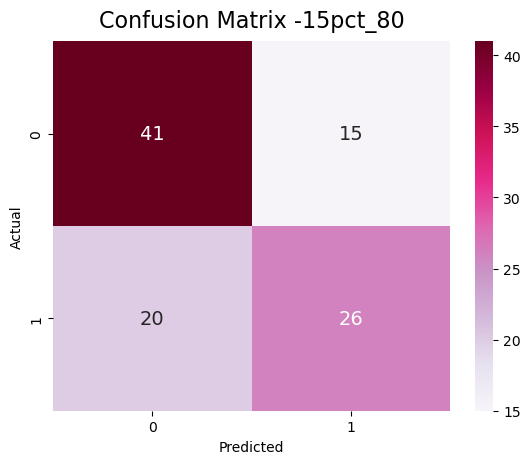

In [ ]:
# Confusion Matrix
sns.heatmap(out["conf_matrix"], annot=True, fmt='d', cmap="PuRd", cbar=True, annot_kws= {"fontsize":14})
plt.title(f"Confusion Matrix -15pct_80", fontsize = 16 , pad = 10)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(plotdir/"CF_Xgboost.png", bbox_inches="tight", dpi=300)
plt.show()